In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew, normaltest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

# Define the function
def adaptive_scaling(dataframe, target_column=None):
    """
    Scales the features in the dataframe based on their distribution characteristics.
    Parameters:
        dataframe (pd.DataFrame): Input dataset.
        target_column (str): Name of the target column to exclude from scaling.
    Returns:
        scaled_df (pd.DataFrame): Scaled dataset with the same columns as the input.
        scaling_info (dict): Information about the scaling method used for each column.
    """
    scaled_df = dataframe.copy()
    scaling_info = {}
    columns = [col for col in dataframe.columns if col != target_column]

    for col in columns:
        print(f"Processing column: {col}")
        # Check for missing values
        if scaled_df[col].isnull().any():
            print(f"Warning: Column '{col}' contains missing values. Imputing with median.")
            scaled_df[col].fillna(scaled_df[col].median(), inplace=True)

        # Evaluate the distribution
        skewness = skew(scaled_df[col])
        _, p_value = normaltest(scaled_df[col])
        
        print(f"  Skewness: {skewness:.2f}, Normality test p-value: {p_value:.4f}")
        
        # Decide on scaling method
        if p_value > 0.05:  # Normally distributed
            print(f"  Applying StandardScaler (data is approximately normal).")
            scaler = StandardScaler()
        elif skewness > 1 or skewness < -1:  # Highly skewed
            print(f"  Applying log transformation followed by MinMaxScaler (data is skewed).")
            scaled_df[col] = np.log1p(scaled_df[col] - scaled_df[col].min() + 1)
            scaler = MinMaxScaler()
        else:  # Mildly skewed or uniform
            print(f"  Applying MinMaxScaler (data is mildly skewed or uniform).")
            scaler = MinMaxScaler()
        
        # Apply scaling
        scaled_values = scaler.fit_transform(scaled_df[col].values.reshape(-1, 1))
        scaled_df[col] = scaled_values.flatten()
        scaling_info[col] = {
            "method": type(scaler).__name__,
            "skewness": skewness,
            "normality_p_value": p_value
        }
        
    return scaled_df, scaling_info

Processing column: normal_data
  Skewness: 0.12, Normality test p-value: 0.2759
  Applying StandardScaler (data is approximately normal).
Processing column: skewed_data
  Skewness: 1.98, Normality test p-value: 0.0000
  Applying log transformation followed by MinMaxScaler (data is skewed).
Processing column: uniform_data
  Skewness: 0.01, Normality test p-value: 0.0000
  Applying MinMaxScaler (data is mildly skewed or uniform).

Scaling Information:
normal_data: {'method': 'StandardScaler', 'skewness': np.float64(0.11680083110533511), 'normality_p_value': np.float64(0.2758883767428564)}
skewed_data: {'method': 'MinMaxScaler', 'skewness': np.float64(1.9808119458203124), 'normality_p_value': np.float64(1.6292261211702495e-92)}
uniform_data: {'method': 'MinMaxScaler', 'skewness': np.float64(0.009550612027921292), 'normality_p_value': np.float64(5.561736177951095e-138)}


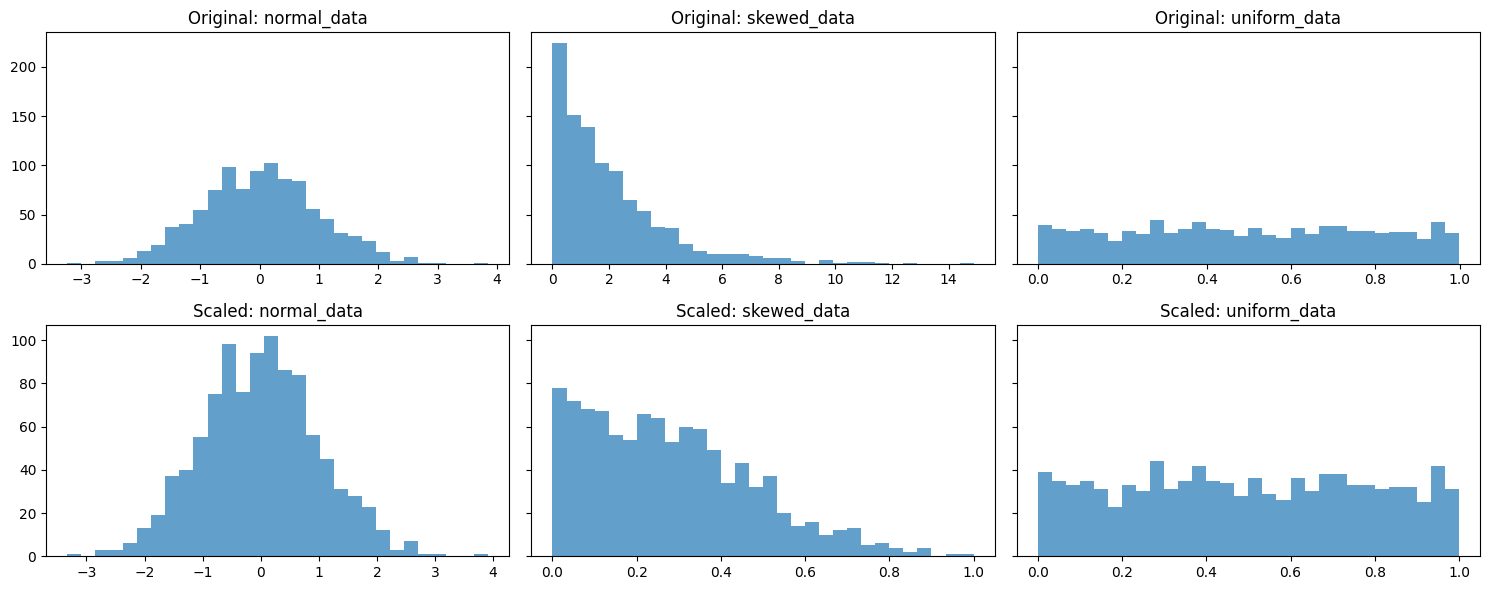

In [3]:
# Example usage with synthetic data
if __name__ == "__main__":
    # Example dataset
    np.random.seed(42)
    data = {
        "normal_data": np.random.normal(loc=0, scale=1, size=1000),
        "skewed_data": np.random.exponential(scale=2, size=1000),
        "uniform_data": np.random.uniform(low=0, high=1, size=1000),
        "target": np.random.rand(1000)  # Target column
    }
    df = pd.DataFrame(data)

    # Apply adaptive scaling
    scaled_df, scaling_info = adaptive_scaling(df, target_column="target")

    # Show results
    print("\nScaling Information:")
    for col, info in scaling_info.items():
        print(f"{col}: {info}")

    # Visualize original vs scaled data
    fig, axes = plt.subplots(nrows=2, ncols=len(df.columns)-1, figsize=(15, 6), sharey='row')
    for i, col in enumerate([col for col in df.columns if col != "target"]):
        axes[0, i].hist(df[col], bins=30, alpha=0.7, label="Original")
        axes[0, i].set_title(f"Original: {col}")
        axes[1, i].hist(scaled_df[col], bins=30, alpha=0.7, label="Scaled")
        axes[1, i].set_title(f"Scaled: {col}")
    plt.tight_layout()
    plt.show()